### Predict winners using Elo rating system

References
1. https://en.wikipedia.org/wiki/Elo_rating_system
* https://www.kaggle.com/kplauritzen/elo-ratings-in-python  
* https://medium.com/swlh/how-i-created-a-league-of-legends-elo-model-using-python-4209461fd0ac  
* https://github.com/sublee/elo  
* https://github.com/HankSheehan/EloPy  

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

### Load the data

In [2]:
data_dir = './march-machine-learning-mania-2017'
df_reg = pd.read_csv(data_dir + '/' + 'RegularSeasonCompactResults.csv')
df_tour = pd.read_csv(data_dir + '/' + 'TourneyCompactResults.csv')
df_seasons = pd.read_csv(data_dir + '/' + 'Seasons.csv')
df_teams = pd.read_csv(data_dir + '/' + 'Teams.csv')

In [3]:
df_reg.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [4]:
df_tour.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [5]:
df_seasons.head()

,Season,Dayzero,Regionw,Regionx,Regiony,Regionz
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


#### Drop the columns that we will not use in this analysis

In [6]:
df = (
    pd.concat([df_reg, df_tour], ignore_index=True)
    .drop(labels=['Wscore', 'Lscore', 'Wloc', 'Numot'], axis=1)
    .sort_values(by=['Season', 'Daynum'])
)

#### Add a new column containing the date each game was played on 

In [7]:
df_seasons['Dayzero'] = pd.to_datetime(df_seasons['Dayzero'])
df['Date'] = df.merge(df_seasons, on='Season').apply(lambda x: x['Dayzero'] + pd.Timedelta(days=x['Daynum']), axis=1)
df = df.drop(labels=['Daynum'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152734 entries, 0 to 150683
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Season  152734 non-null  int64         
 1   Wteam   152734 non-null  int64         
 2   Lteam   152734 non-null  int64         
 3   Date    152734 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 5.8 MB


There are no missing data.

#### Clear pandas dataframes we don't need any more

In [9]:
del df_reg, df_tour

#### Date of first game played by a team

In [10]:
df_teams

,Team_Id,Team_Name
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M
...,...,...
359,1460,Wright St
360,1461,Wyoming
361,1462,Xavier
362,1463,Yale


In [11]:
df_first_game_date = pd.DataFrame(df.groupby('Wteam')['Date'].min())
df_first_game_date = df_first_game_date.merge(
    df.groupby('Lteam')['Date'].min(), 
    left_index=True, right_on='Lteam'
)
df_first_game_date = df_first_game_date[['Date_x', 'Date_y']].min(axis=1)
df_first_game_date.index = df_first_game_date.index.rename('Team')
df_first_game_date

Team
1101   2013-02-06
1102   1984-11-24
1103   1984-12-01
1104   1984-11-26
1105   1999-02-13
          ...    
1460   1987-03-08
1461   1984-12-04
1462   1984-12-01
1463   1984-11-30
1464   1984-11-26
Length: 364, dtype: datetime64[ns]

#### Elo ratings model

In [12]:
from collections import defaultdict


class Player:
    def __init__(self, player_id):
        self.id = player_id
        self.rating_date = []
        self.rating = []

        
    def update_rating(self, rating_date, rating):
        self.rating_date.append(rating_date)
        self.rating.append(rating)
        
        
    def __repr__(self):
        return (
            'id: ' + str(self.id) + ', '
            'rating: ' + str([(d, r) for (d, r) in zip(self.rating_date, self.rating)])
        )


class EloRatingsUpdater:
    def __init__(self):
        self.base_rating = 1500
        self.width = 400
        self.k_factor = 64
        self.players = defaultdict(Player)  # {player_id, Player object}
        
    
    def __repr__(self):
        return str([v for k, v in self.players.items()])
    
    
    def add_player(self, player_id, game_date, rating=None):
        if rating == None:
            rating = self.base_rating
        new_player = Player(player_id)
        new_player.update_rating(game_date, rating)
        self.players[player_id] = new_player
        return new_player
    
    
    def predict_proba(self, game_date, winner_id, looser_id):
        winner = self.players.get(winner_id, None)
        looser = self.players.get(looser_id, None)
        if not winner:
            winner = self.add_player(winner_id, game_date)
        if not looser:
            looser = self.add_player(looser_id, game_date)
        winner_rating = winner.rating[-1]
        looser_rating = looser.rating[-1]
        expected_proba = self.expected_win_prob(winner_rating, looser_rating)
        change = self.k_factor*(1 - expected_proba)
        winner.update_rating(game_date, winner_rating + change)
        looser.update_rating(game_date, looser_rating - change)
        #print (winner)
        #print (looser)
        #print ()
        return expected_proba
    
    
    def expected_win_prob(self, winner_rating, looser_rating):
        return 1/(1 + 10**((looser_rating - winner_rating)/self.width))
        
    
eu = EloRatingsUpdater()
eu.predict_proba('2021-02-01', 1, 2)
eu.predict_proba('2021-02-02', 1, 2)
eu.predict_proba('2021-02-03', 2, 1)
eu.predict_proba('2021-02-04', 2, 1)
print (eu)

[id: 1, rating: [('2021-02-01', 1500), ('2021-02-01', 1532.0), ('2021-02-02', 1558.1711618358436), ('2021-02-03', 1515.838968826975), ('2021-02-04', 1480.929381086808)], id: 2, rating: [('2021-02-01', 1500), ('2021-02-01', 1468.0), ('2021-02-02', 1441.8288381641564), ('2021-02-03', 1484.161031173025), ('2021-02-04', 1519.070618913192)]]


In [13]:
def predict_probability_of_winning(df):
    eu = EloRatingsUpdater()
    y_pred_proba = []
    for _, game in df.iterrows():
        y_pred_proba.append(eu.predict_proba(game['Date'], game['Wteam'], game['Lteam']))
    return y_pred_proba
    
df['y_pred_proba'] = predict_probability_of_winning(df)

In [14]:
df.head()

,Season,Wteam,Lteam,Date,y_pred_proba
0,1985,1228,1328,1984-11-18,0.5
1,1985,1106,1354,1984-11-23,0.5
2,1985,1112,1223,1984-11-23,0.5
3,1985,1165,1432,1984-11-23,0.5
4,1985,1192,1447,1984-11-23,0.5


#### Model evaluation

In [15]:
num_true_positives = (
    sum(df['y_pred_proba'] > 0.5) + 
    sum(df['y_pred_proba'] == 0.5)/2  
        # When predicted probability is 50 %, we choose winner at random. 
        # So half of the prections will be correct.
)
tpr = num_true_positives/len(df)
print ('True positive rate: {:.2f} %'.format(tpr*100))

True positive rate: 70.04 %


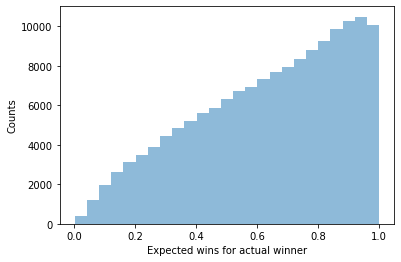

In [16]:
df['y_pred_proba'].hist(bins=25, alpha=.5, grid=False)
plt.xlabel('Expected wins for actual winner')
plt.ylabel('Counts');

In [17]:
def plot_roc_curve(y_pos, y_pos_pred_proba):
    y_neg = np.zeros_like(y_pos)
    y_neg_pred_proba = 1 - y_pos_pred_proba
    
    y = np.concatenate((y_pos, y_neg))
    y_score = np.concatenate((y_pos_pred_proba, y_neg_pred_proba))
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, '-', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    
    
def confusion_matrix_plot(y_pos, y_pos_pred_proba, normalize=None):
    y_neg = np.zeros_like(y_pos)
    y_neg_pred_proba = 1 - y_pos_pred_proba
    
    y_pos_pred = 1*(y_pos_pred_proba > 0.5)
    y_neg_pred = 1*(y_pos_pred_proba < 0.5)
    
    y = np.concatenate((y_pos, y_neg))
    y_pred = np.concatenate((y_pos_pred, y_neg_pred))
    
    cm = confusion_matrix(y, y_pred, normalize=normalize)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return disp.plot(include_values=True, cmap=plt.cm.Blues)    

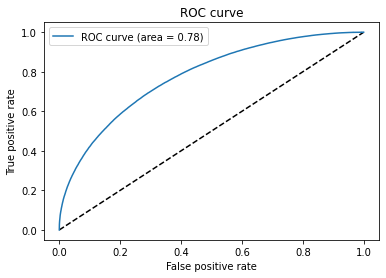

In [18]:
plot_roc_curve(np.ones(len(df['y_pred_proba'])), df['y_pred_proba'])

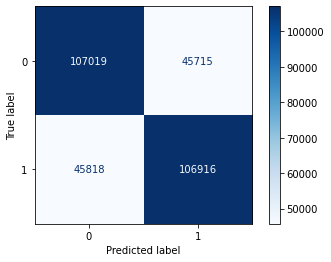

In [19]:
confusion_matrix_plot(np.ones(len(df['y_pred_proba'])), df['y_pred_proba']);

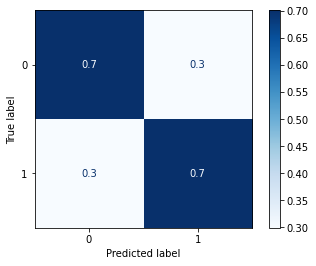

In [20]:
confusion_matrix_plot(np.ones(len(df['y_pred_proba'])), df['y_pred_proba'], normalize='true');

#### Test on data after 2010

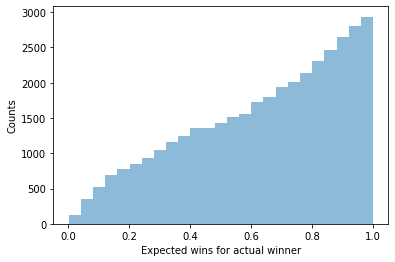

In [21]:
df[df['Season'] > 2010]['y_pred_proba'].hist(bins=25, alpha=.5, grid=False)
plt.xlabel('Expected wins for actual winner')
plt.ylabel('Counts');

In [22]:
num_true_positives = (
    sum(df[df['Season'] > 2010]['y_pred_proba'] > 0.5) + 
    sum(df[df['Season'] > 2010]['y_pred_proba'] == 0.5)/2  
        # When predicted probability is 50 %, we choose winner at random. 
        # So half of the prections will be correct.
)
tpr = num_true_positives/len(df[df['Season'] > 2010]['y_pred_proba'])
print ('True positive rate: {:.2f} %'.format(tpr*100))

True positive rate: 70.50 %
